In [131]:
from src.datasets.city import City
from torch.utils.data import DataLoader
import torch
from src.models.unet.unet_model import UNet
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from src.metrics.segmentation import _fast_hist, per_class_pixel_accuracy, jaccard_index

In [110]:
data_dir = '/home/dsola/repos/PGA-Net/data/'
batch_size = 1

train_set = City(data_dir, split='train', is_transform=True)
val_set = City(data_dir, split='val', is_transform=True)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True,
                        drop_last=True)

Found 2975 train images
Found 500 val images


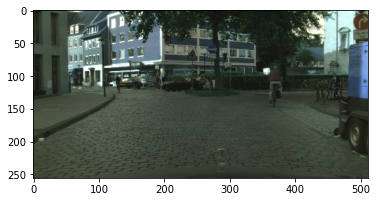

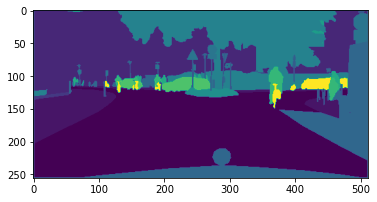

In [151]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet(n_channels=3, n_classes=20, bilinear=True).to(device=device)

checkpoint_path = '/home/dsola/repos/PGA-Net/checkpoints/eager_galaxy_144_unet_ignore_20_cityscapes/epoch12.pth'

model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()
out = nn.Softmax(dim=1)

batch = val_set[8]

img = batch['image']
mask = batch['mask']

plt.figure()
plt.imshow(img.permute(1,2,0).detach().numpy());

plt.figure()
plt.imshow(mask.numpy());

In [152]:
img = batch['image'].to(device=device).unsqueeze(0)
mask = batch['mask'].to(device=device, dtype=torch.long).unsqueeze(0)

with torch.no_grad():
    output = model(img)

In [153]:
sftmx = out(output)
argmx = torch.argmax(sftmx, dim=1)

In [154]:
print(output.shape)
print(sftmx.shape)
print(argmx.shape)

torch.Size([1, 20, 256, 512])
torch.Size([1, 20, 256, 512])
torch.Size([1, 256, 512])


In [155]:
m = mask.squeeze(0)
a = argmx.squeeze(0)
m = m.detach().cpu().numpy()
a = a.detach().cpu().numpy()

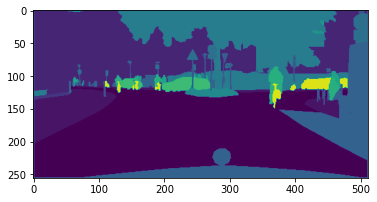

In [156]:
fig, ax = plt.subplots()
ax.imshow(m, vmin=0, vmax=19)

In [157]:
np.unique(m)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 18])

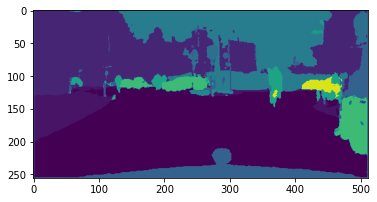

In [158]:
fig, ax = plt.subplots()
ax.imshow(a, vmin=0, vmax=19)

In [159]:
np.unique(a)

array([ 0,  1,  2,  3,  5,  6,  7,  8,  9, 10, 11, 13, 18])

In [166]:
hist = _fast_hist(mask.squeeze(0).to(dtype=torch.long), argmx.squeeze(0).to(dtype=torch.long), 19)

In [167]:
per_class_pixel_accuracy(hist)

(tensor(0.4537, device='cuda:0'),
 tensor([0.9825, 0.8203, 0.9720, 0.0000, 0.0000, 0.3038, 0.5331, 0.7715, 0.9171,
         0.4110, 0.9091, 0.6378, 0.0000, 0.9087, 0.0000, 0.0000, 0.0000, 0.0000,
         0.4537], device='cuda:0'))

In [168]:
jaccard_index(hist)

(tensor(0.3492, device='cuda:0'),
 tensor([0.9056, 0.7573, 0.8688, 0.0000, 0.0000, 0.2166, 0.4958, 0.6601, 0.8948,
         0.4110, 0.6667, 0.1106, 0.0000, 0.2759, 0.0000, 0.0000, 0.0000, 0.0000,
         0.3717], device='cuda:0'))

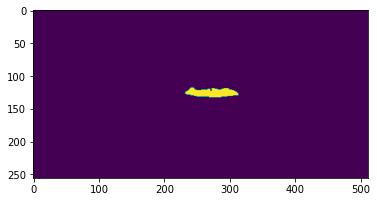

In [177]:
plt.imshow(m==9)

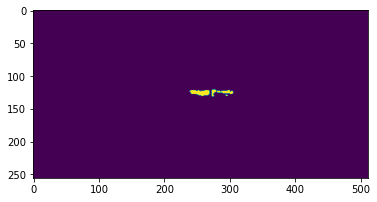

In [178]:
plt.imshow(a==9)